In [ ]:
%%capture
! pip install timm

In [ ]:
import os
import cv2
import tarfile
import numpy as np
import pandas as pd
from math import ceil
from time import time
from tqdm.auto import tqdm
import multiprocessing as mp
from matplotlib import pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

import timm
import torch
import torchvision
import torchsummary
from torch import nn
from torch.optim import Adam
from torchvision import transforms, utils
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

%matplotlib inline

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

# Setting up GPU

In [ ]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
device

'cuda:0'

# Extracting images to local storage

!rm -r /content/Dataset

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/Dataset.tar.xz')
my_tar.extractall()
my_tar.close()

my_tar = tarfile.open('/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Dataset/data_bordered.tar.xz')
my_tar.extractall()
my_tar.close()

# Image path list

In [ ]:
original_image_path = '/content/Dataset/1.training/1.training'
#cutmix_image_path = '/content/Dataset/cutmix_augmentation'
constant_image_path = '/content/data_border_constant'
reflect_image_path = '/content/data_border_reflect'

In [ ]:
image_path_list = []

In [ ]:
def img_list(data_path):
  # getting list of all the images
  images = os.listdir(data_path)
  #exc_list = ['[1, 1, 0]', '[1, 0, 1]', '[0, 1, 1]', '[1, 1, 1]']
  # setting the flag based on the image path
  '''
  if path == orig_image_path:
    flag = 0
  else:
    flag = 1
  '''
  # don't need the flag, just resize all the images while loading to (224, 224)

  # adding to the image_path_list
  for i in images:
    # adding the image path, flag and the label
    #image_path_list[0].append([path + '/' + str(i), flag, list(map(int, i[-13:-4].strip('][').split(', ')))])
    #print(list(map(int, i[-13:-4].strip('][').split(', '))))
    if 'DS_S' in str(i):
      continue
    image_path_list.append([data_path + '/' + str(i), list(map(int, i[-13:-4].strip('][').split(', ')))])

In [ ]:
# loading image paths
img_list(original_image_path)
#img_list(cutmix_image_path)
img_list(constant_image_path)
img_list(reflect_image_path)

In [ ]:
np.random.shuffle(image_path_list)

In [ ]:
image_path_list = [x for x in image_path_list if ('[1, 0, 0]' in x[0]) or\
                                                 ('[0, 1, 0]' in x[0]) or\
                                                 ('[0, 0, 1]' in x[0])]

# sorting the image path list from the original list to match the number of tumor-stroma pair to the rest of the dataset and the cut-mix aug data
tumor = [x for x in image_path_list if '[1, 0, 0]' in x[0]]
stroma = [x for x in image_path_list if '[0, 1, 0]' in x[0]]
normal = [x for x in image_path_list if '[0, 0, 1]' in x[0]]
tum_str = [x for x in image_path_list if '[1, 1, 0]' in x[0]][:4000]
str_nor = [x for x in image_path_list if '[0, 1, 1]' in x[0]]
tum_nor = [x for x in image_path_list if '[1, 0, 1]' in x[0]]
all_tis = [x for x in image_path_list if '[1, 1, 1]' in x[0]]

np.random.shuffle(tumor)
np.random.shuffle(stroma)
np.random.shuffle(normal)
np.random.shuffle(tum_str)
np.random.shuffle(str_nor)
np.random.shuffle(tum_nor)
np.random.shuffle(all_tis)

test_list =[]
train_list = []

# train test splits
tumor, test = train_test_split(tumor, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

stroma, test = train_test_split(stroma, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

normal, test = train_test_split(normal, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

tum_str, test = train_test_split(tum_str, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

str_nor, test = train_test_split(str_nor, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

tum_nor, test = train_test_split(tum_nor, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

all_tis, test = train_test_split(all_tis, test_size = 0.2, train_size = 0.8, random_state = 42)
test_list.extend(test)

train_list.extend(tumor)
train_list.extend(stroma)
train_list.extend(normal)
train_list.extend(tum_str[:2000])
train_list.extend(str_nor)
train_list.extend(tum_nor)
train_list.extend(all_tis)

np.random.shuffle(train_list)

In [ ]:
len(image_path_list)

14079

len(test_list)

## Creating the dataset class

In [ ]:
# Creating the dataset class for the data

class LUAD(Dataset):
  """Lung Adenocarcinoma Histopathological images."""
  
  def __init__(self, image_list, transform = None):
    
    """
      Args:
        image_list: csv/list/numpy array containing image paths, flag and labels.
        transform (callable, optional): Optional transform to be applied on a sample.
        """
    #Loading the csv file containing the image paths and one-hot encoded labels
    #self.image_paths_labels = pd.read_csv(csv_file)
    self.image_list = image_list
    self.transform = transform

  def __len__(self):
    return len(self.image_list)
  
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
      idx = idx.tolist()
    
    # code when input is a csv file
    '''
    image = cv2.imread(image_paths_labels.iloc[idx, 0])
    image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W) do this in transforms
    labels = self.image_paths_labels.iloc[idx, 1]
    labels = np.array([labels])
    labels = labels.astype('int').reshape(-1, 3)        # check what exactly to do with this
    sample = {'image': image, 'labels': labels}
    '''
    #print(idx) keeps printing 
    # code when the input is a list of image paths and labels
    image = cv2.imread(self.image_list[idx][0])
    #image = transforms.ToTensor()(image)                # converts cv2 image (H, W, C) to pytorch tensor (C, H, W)
    labels = self.image_list[idx][1]
    labels = np.array([labels])
    #labels = labels.astype('int').reshape(-1, 3) #.argmax(axis=1)        # reshapes the labels array into (n, 3) array
    labels = labels.astype('float32').reshape(-1)
    #sample = {'image': image, 'labels': labels}
    
    if self.transform:
      #sample = self.transform(sample)
      image = self.transform(image)
    
    return image, labels

14079
0 (224, 224, 3) (3,)
1 (224, 224, 3) (3,)
2 (224, 224, 3) (3,)


/usr/local/lib/python3.7/dist-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


3 (224, 224, 3) (3,)


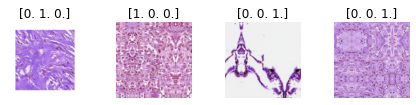

In [ ]:
# check if the dataloader works
check_loader = LUAD(image_list=image_path_list)

print(len(check_loader))
fig = plt.figure()

for i in range(len(check_loader)):
    #sample = check_loader[i]
    image, labels = check_loader[i]

    print(i, image.shape, labels.shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    #ax.set_title(sample['labels'])
    ax.set_title(labels)
    ax.axis('off')
    #plt.imshow(sample['image'])
    plt.imshow(image)

    if i == 3:
        plt.show()
        break

In [ ]:
random_augs = [#transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5, hue=0.5),
               #transforms.RandomGrayscale(p=0.1),            #Grayscale(num_output_channels=3),
               #transforms.RandomAffine(degrees=(30, 70), translate=(0.1, 0.3), scale=(0.5, 0.75)),
               transforms.RandomHorizontalFlip(p=0.5),
               transforms.RandomVerticalFlip(p=0.5),
               transforms.RandomRotation(30),
               #transforms.GaussianBlur(kernel_size=(5, 9), sigma=(0.1, 5)),
               #transforms.RandomPerspective(distortion_scale=0.6, p=1.0),
               #transforms.RandomAdjustSharpness(sharpness_factor=2),
               ]

# creatin the train dataset
train_dataset = LUAD(image_path_list,
                     transform = transforms.Compose([transforms.ToTensor(),
                                                     transforms.Resize((224, 224)),
                                                     #transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),
                                                     transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
                                                     transforms.RandomApply(random_augs, p=0.6),
                                                     ]))

# creating the test dataset
#test_dataset = LUAD(test_list,
#                    transform = transforms.Compose([transforms.ToTensor(),
#                                                    transforms.Resize((224, 224)),
#                                                    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]),]
#                                                    ))

In [ ]:
batch_size = 32

In [ ]:
# train dataloader
train_dataloader = DataLoader(train_dataset,
                              batch_size = batch_size,
                              shuffle = True,
                              num_workers = 1,
                              )

# test dataloader
#test_dataloader = DataLoader(test_dataset,
#                             batch_size = batch_size,
#                             shuffle = True,
#                             num_workers = 1,
#                             )

In [ ]:
len(train_dataloader)

440

# Creating the model

In [ ]:
model_swin_base_7_4_224 = timm.create_model('swin_base_patch4_window7_224', pretrained = True, num_classes = 3,
                                               drop_rate = 0.2, attn_drop_rate = 0.2).to(device)
#print(model(torch.randn(1, 3, 224, 224)))

/usr/local/lib/python3.7/dist-packages/torch/functional.py:478: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  ../aten/src/ATen/native/TensorShape.cpp:2894.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [ ]:
torchsummary.summary(model_swin_base_7_4_224, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 56, 56]           6,272
         LayerNorm-2            [-1, 3136, 128]             256
        PatchEmbed-3            [-1, 3136, 128]               0
           Dropout-4            [-1, 3136, 128]               0
         LayerNorm-5            [-1, 3136, 128]             256
            Linear-6              [-1, 49, 384]          49,536
           Softmax-7            [-1, 4, 49, 49]               0
           Dropout-8            [-1, 4, 49, 49]               0
            Linear-9              [-1, 49, 128]          16,512
          Dropout-10              [-1, 49, 128]               0
  WindowAttention-11              [-1, 49, 128]               0
         Identity-12            [-1, 3136, 128]               0
        LayerNorm-13            [-1, 3136, 128]             256
           Linear-14            [-1, 31

### Checking model properties

In [ ]:
next(model_swin_base_7_4_224.parameters()).is_cuda

True

In [ ]:
out = model_swin_base_7_4_224(torch.randn(10, 3, 224, 224).to(device))
out

tensor([[-0.2045, -0.0490, -0.2094],
        [-0.3830, -0.3506, -0.1796],
        [-0.4343, -0.1754, -0.2372],
        [-0.3944,  0.0046,  0.0291],
        [-0.2232, -0.0197, -0.2261],
        [-0.3532, -0.0062, -0.3583],
        [-0.1284,  0.0041, -0.5738],
        [-0.2257, -0.0799, -0.0761],
        [-0.3146, -0.3780, -0.2461],
        [-0.3132, -0.1221, -0.0576]], device='cuda:0',
       grad_fn=<AddmmBackward0>)

In [ ]:
y_p = nn.functional.softmax(out, dim = -1)
y_p

tensor([[0.3161, 0.3693, 0.3146],
        [0.3069, 0.3170, 0.3761],
        [0.2846, 0.3687, 0.3466],
        [0.2489, 0.3709, 0.3802],
        [0.3103, 0.3803, 0.3094],
        [0.2933, 0.4149, 0.2918],
        [0.3594, 0.4103, 0.2302],
        [0.3014, 0.3487, 0.3500],
        [0.3323, 0.3119, 0.3558],
        [0.2856, 0.3457, 0.3687]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [ ]:
#y_p = y_p.round().detach().cpu().numpy()
y_p = y_p.round()
#y_p = nn.Threshold(0.25, 1.0)(y_p)
y_p

tensor([[0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.],
        [0., 0., 0.]], device='cuda:0', grad_fn=<RoundBackward0>)

In [ ]:
y_p.shape

torch.Size([10, 3])

In [ ]:
'''
l = np.array([[0, 0, 1],
              [1, 0, 0],
              [0, 0, 1],
              [0, 0, 1],
              [0, 0, 1],
              [0, 0, 1],
              [0, 1, 0],
              [1, 0, 0],
              [0, 0, 1],
              [0, 0, 1],]).astype('float32')
'''

l = np.array([[1., 0., 0.],
              [0., 0., 1.],
              [0., 1., 0.],
              [0., 0., 1.],
              [1., 0., 0.],
              [0., 1., 0.],
              [0., 0., 1.],
              [0., 1., 0.],
              [0., 1., 0.],
              [0., 1., 0.]]).astype('float32')

In [ ]:
l = torch.tensor(l).to(device)

In [ ]:
y_p.dtype

torch.float32

In [ ]:
accuracy_score(l.cpu().detach().numpy().argmax(axis=1),
               y_p.cpu().detach().numpy().argmax(axis=1))

0.2

In [ ]:
loss = nn.CrossEntropyLoss()

In [ ]:
loss(out, l)

tensor(1.0894, device='cuda:0', grad_fn=<DivBackward1>)

## Training and validation

In [ ]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               opt: torch.optim.Optimizer,
               eval_fn = accuracy_score,
               device: torch.device = device
               ):
  
  train_loss, train_acc = 0, 0
  model.train()
  loop = tqdm(enumerate(data_loader), total=len(data_loader), leave=False)
  for batch, (x, y) in loop:
    
    #if (batch % 20 == 0) or (batch == len(data_loader)-1): print(f'batch: {batch}')
    #print(f'batch: {batch}')
    #x = data['image']
    #y = data['labels']
    # send data to GPU
    x, y = x.to(device), y.to(device)
    
    #clear gradients
    opt.zero_grad()

    # forward pass
    model_out = model(x)
    
    y_pred = nn.functional.softmax(model_out, dim = -1)
    
    # calculate loss
    loss = loss_fn(model_out, y)
    
    train_loss += loss
    train_acc += eval_fn(y.cpu().detach().numpy().argmax(axis=1),
                         y_pred.cpu().detach().numpy().argmax(axis=1))

    # back-prop
    loss.backward()

    # optimize
    opt.step()

  # Calculate loss and accuracy per epoch and print out what's happening
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.5f}")

In [ ]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              eval_fn = accuracy_score,
              device: torch.device = device
              ):
  test_loss, test_acc = 0, 0
  model.eval() # put model in eval mode
  
  # Turn on inference context manager
  with torch.inference_mode(): 
    for (X, y) in data_loader:

      #x = data['image']
      #y = data['labels']
      
      # Send data to GPU
      X, y = X.to(device), y.to(device)
      
      # 1. Forward pass
      model_out = model(X)
      test_pred = torch.sigmoid(model_out).round()
      
      # 2. Calculate loss and accuracy
      test_loss += loss_fn(model_out, y)
      test_acc += eval_fn(y.cpu().detach().numpy().astype('float32'),
                          test_pred.cpu().detach().numpy().astype('float32'))
      
    # Adjust metrics and print out
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)
    print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.5f}\n")
    return test_loss, test_acc

In [ ]:
model_save_path = '/content/drive/MyDrive/Newcastle_University/Final_Project_Dissertation/Models/model_swin_base_7_4_224.pth'

In [ ]:
epochs = 25

In [ ]:
valid_acc = -np.inf

In [ ]:
for epoch in tqdm(range(epochs)):

  print(f"Epoch: {epoch}\n---------")
  train_step(data_loader=train_dataloader,
             model=model_swin_base_7_4_224,
             loss_fn=nn.CrossEntropyLoss(),
             opt=torch.optim.SGD(model_swin_base_7_4_224.parameters(), lr=0.0001,
                                 nesterov=True, momentum=0.01),
             eval_fn=accuracy_score
             )
  
  '''
  # validation named as test step
  ep_v_loss, ep_v_acc = test_step(data_loader=test_dataloader,
                                  model=model_vit_base_patch16_224,
                                  loss_fn=nn.MultiLabelSoftMarginLoss(),
                                  eval_fn=accuracy_score
                                  )
  
  if ep_v_acc > valid_acc:
    print(f"accuracy increased from {valid_acc} to {ep_v_acc} saving model to: {model_save_path}")
    torch.save(obj = model_vit_base_patch16_224.state_dict(),
               f = model_save_path)
    valid_acc = ep_v_acc
  
  else:
    print(f"accuracy did not increased from {valid_acc}")
'''
torch.save(obj = model_swin_base_7_4_224.state_dict(), f = model_save_path)

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 0
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 1.06834 | Train accuracy: 0.42753
Epoch: 1
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 1.00392 | Train accuracy: 0.51510
Epoch: 2
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.91157 | Train accuracy: 0.62171
Epoch: 3
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.79006 | Train accuracy: 0.69635
Epoch: 4
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.66550 | Train accuracy: 0.75389
Epoch: 5
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.56205 | Train accuracy: 0.79587
Epoch: 6
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.47777 | Train accuracy: 0.82599
Epoch: 7
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.41481 | Train accuracy: 0.84737
Epoch: 8
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.36836 | Train accuracy: 0.86234
Epoch: 9
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.33991 | Train accuracy: 0.87513
Epoch: 10
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.31545 | Train accuracy: 0.88131
Epoch: 11
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.28883 | Train accuracy: 0.89346
Epoch: 12
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.27887 | Train accuracy: 0.89779
Epoch: 13
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.26196 | Train accuracy: 0.90390
Epoch: 14
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.25755 | Train accuracy: 0.90588
Epoch: 15
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.24197 | Train accuracy: 0.91398
Epoch: 16
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.23271 | Train accuracy: 0.91541
Epoch: 17
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.22799 | Train accuracy: 0.91661
Epoch: 18
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.21659 | Train accuracy: 0.92308
Epoch: 19
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.20787 | Train accuracy: 0.92336
Epoch: 20
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.20622 | Train accuracy: 0.92435
Epoch: 21
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.20318 | Train accuracy: 0.92400
Epoch: 22
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.19884 | Train accuracy: 0.92571
Epoch: 23
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.20057 | Train accuracy: 0.92925
Epoch: 24
---------


  0%|          | 0/440 [00:00<?, ?it/s]

Train loss: 0.19361 | Train accuracy: 0.93039
